# Observational impacts from compound modes

This file grabs the observed rainfall and temperature anomalies for each yeah and season and matches them with the events identifed in the obsIndeces file

In [1]:
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb
%run utils/emergence.ipynb

# Load the Data

In [3]:
eventsXr=xarray.open_dataset('results/obsEvents.nc')

In [4]:
#anoms have already been calculated - see prelim/adcdPrTAnoms.ipynb file
impactXr=xarray.open_dataset('results/observPrTmaxAnoms.nc')

In [5]:
eventsLs = {
    'summer':['nino34','eIndex', 'nino3', 'cIndex','nino4', 'dmi','eastIO','samSummer'],
    'winter':['nino34','eIndex', 'nino3', 'cIndex', 'nino4','dmi','eastIO','samWinter']
}

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [6]:
#change rainfall into % 
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prAnomWinter/(impactXr['prWinter']+impactXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prAnomSummer/(impactXr['prWinter']+impactXr['prSummer'])*100)

tsXr=(impactXr[['tsAnomWinter','tsAnomSummer']])
tsXr=tsXr.rename({'tsAnomWinter':'Winter Temp','tsAnomSummer':'Summer Temp'})

In [7]:
detrendTsXr=tsXr-tsXr.rolling(year=11,min_periods=5,center=True).mean('year')

# Trends

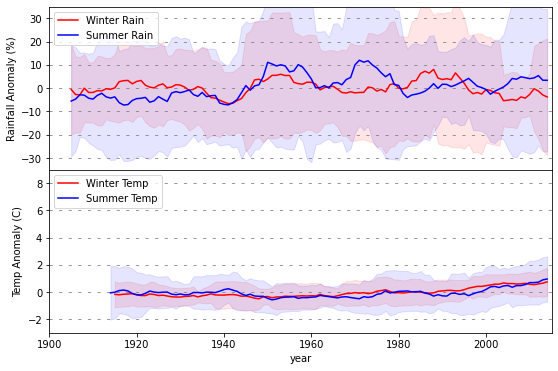

In [8]:
Z=1.96
mainColor=['red','blue','green','orange','purple']
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
dataVars=['Winter Rain','Summer Rain']
for i in range(0,len(dataVars)):
    iVar=dataVars[i]
    mean=domain(prXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).mean()
    std=domain(prXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).std()
    mean.plot(color=mainColor[i])
    plt.fill_between(
        mean.year.values,
        mean+Z*std,
        mean-Z*std,
        color=mainColor[i],
        alpha=0.1
    )
plt.legend(dataVars,loc='upper left')
plt.ylabel('Rainfall Anomaly (%)')
plt.xlim([1900,2015])
plt.ylim([-35,35])
plt.xticks([])
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplot(2,1,2)
dataVars=['Winter Temp','Summer Temp']
for i in range(0,len(dataVars)):
    iVar=dataVars[i]
    mean=domain(tsXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).mean()
    std=domain(tsXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).std()
    mean.plot(color=mainColor[i])
    plt.fill_between(
        mean.year.values,
        mean+Z*std,
        mean-Z*std,
        color=mainColor[i],
        alpha=0.1
    )
plt.legend(dataVars,loc='upper left')
plt.xlim([1900,2015])
plt.ylim([-3,9])
plt.ylabel('Temp Anomaly (C)')
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplots_adjust(hspace=0)




# Anoms for indiv indices

Fire:pos
winter


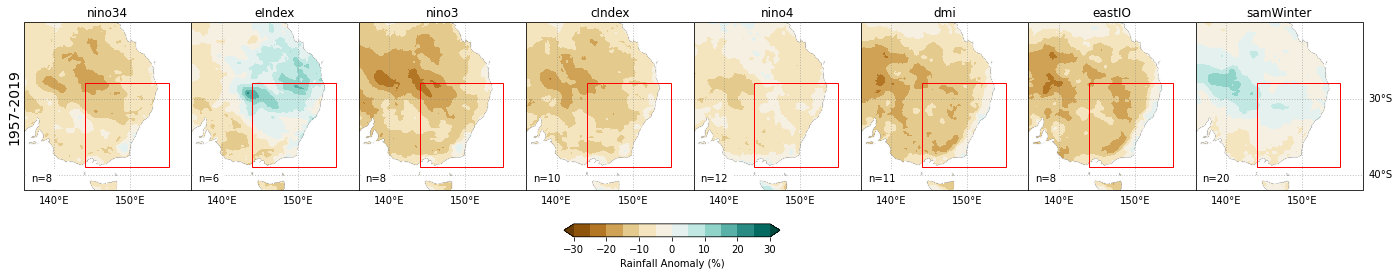

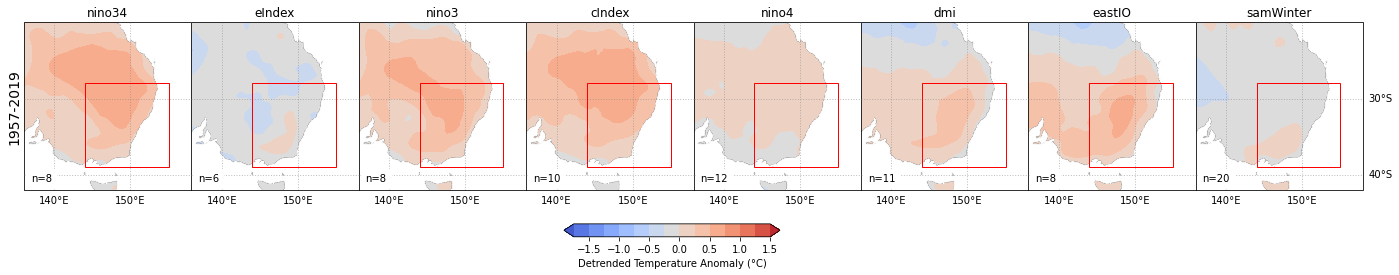

summer


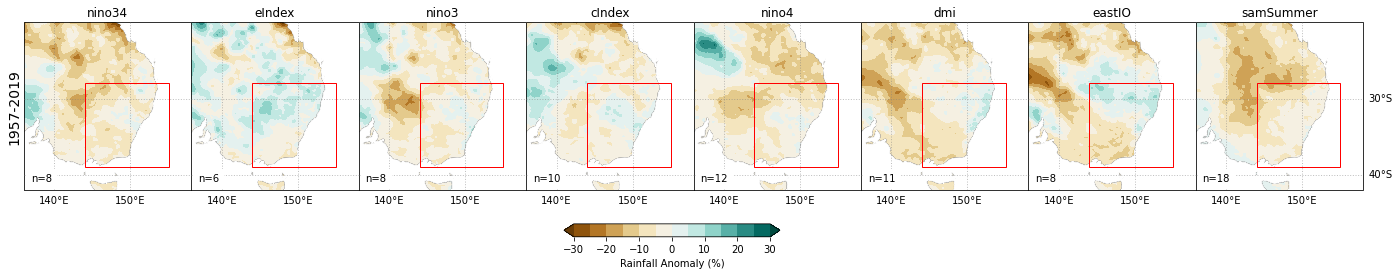

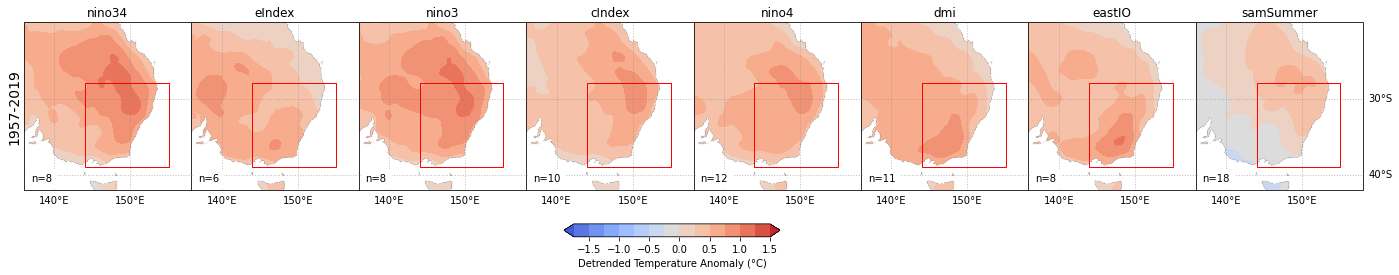

Fire:neg
winter


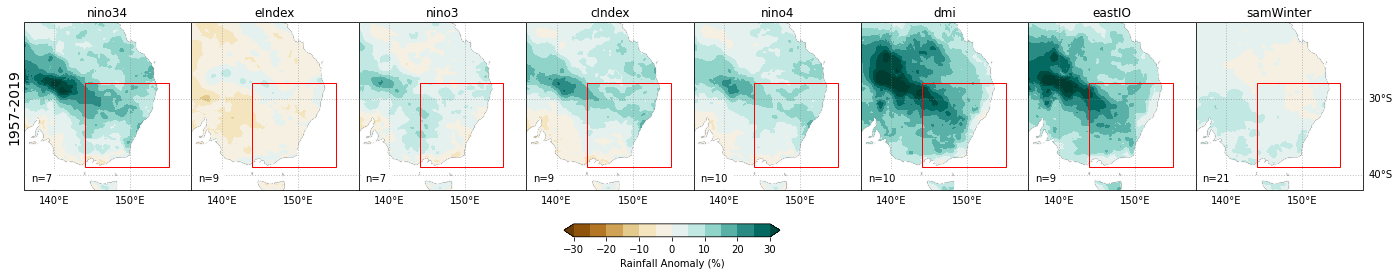

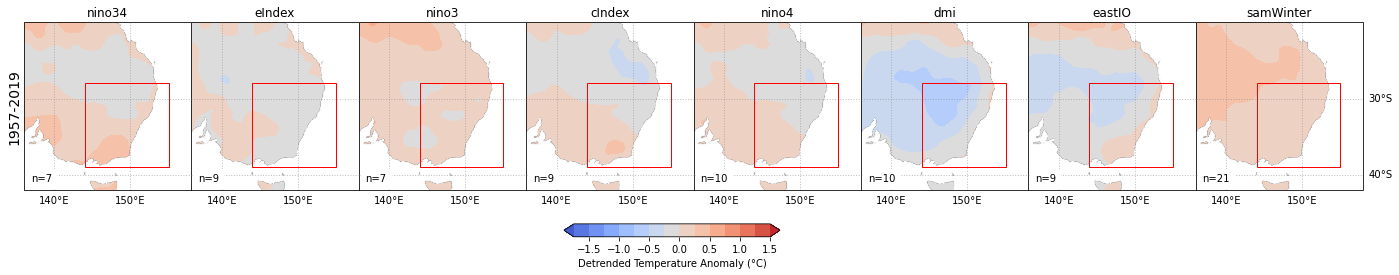

summer


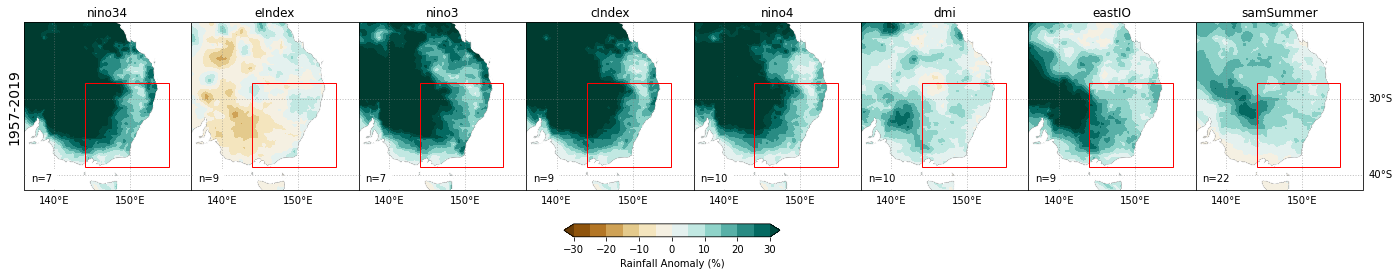

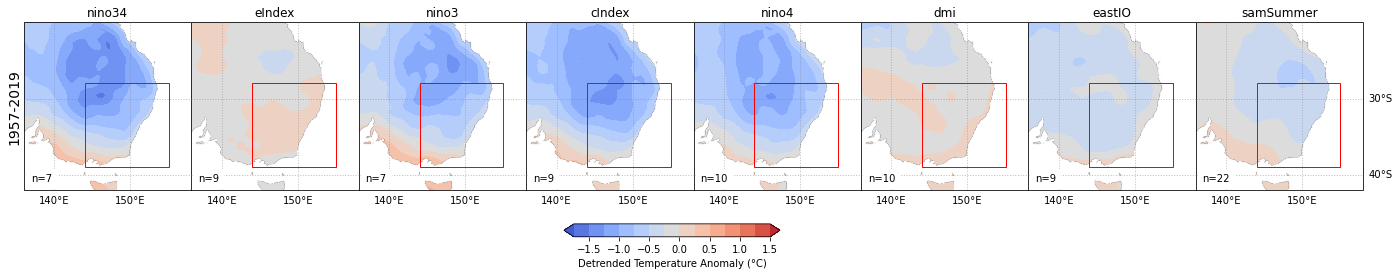

In [9]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason], #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()

# Compound them and see what happens

In [10]:
allCompounds=compound.compound(eventsXr)

nino4DmiSamsummer
nino4DmiSamwinter
nino4EastioSamsummer
nino4EastioSamwinter
nino3DmiSamsummer
nino3DmiSamwinter
nino3EastioSamsummer
nino3EastioSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
ecCombinedEastioSamsummer
ecCombinedEastioSamwinter
nino34DmiSamsummer
nino34DmiSamwinter
nino34EastioSamsummer
nino34EastioSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter
cIndexEastioSamsummer
cIndexEastioSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
eIndexEastioSamsummer
eIndexEastioSamwinter


In [11]:
indexSet='ecCombinedDmiSam'

In [12]:
eventsList=['enso+iod', 'enso+sam', 'iod+sam', 'all3']

Fire:pos
winter


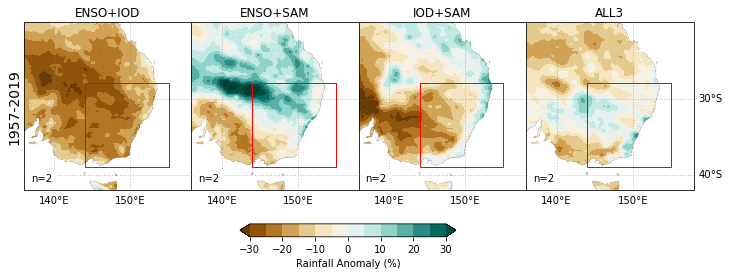

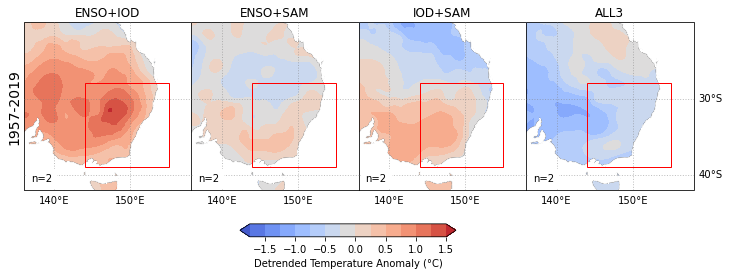

summer


/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


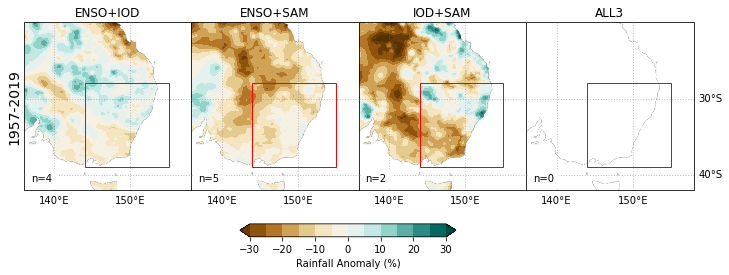

/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


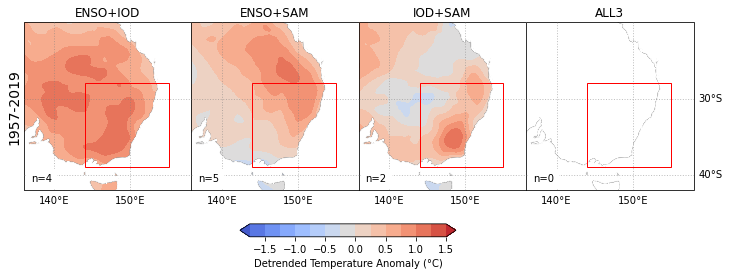

Fire:neg
winter


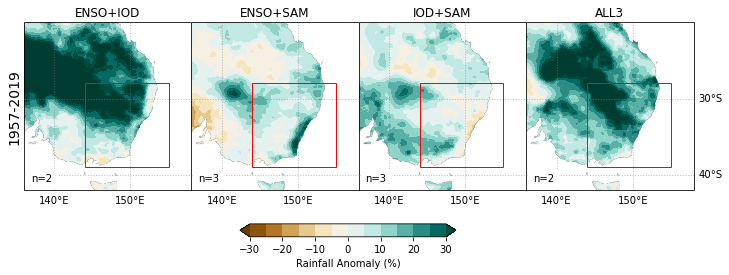

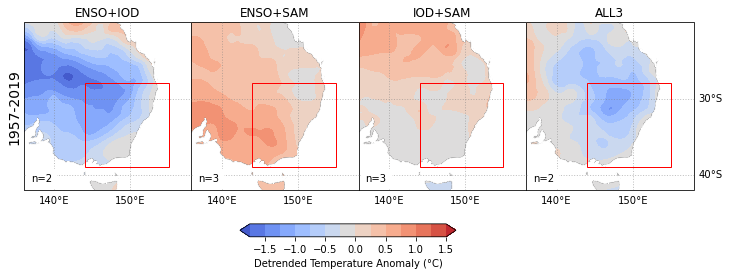

summer


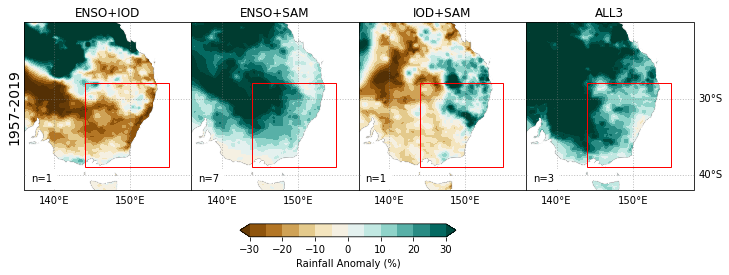

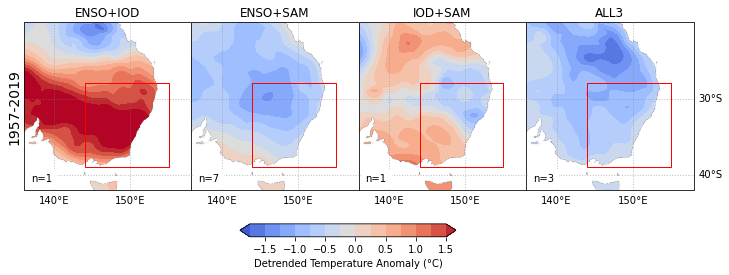

In [22]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('ALL3')
        
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.savefig(
            'figures/obsCompoundImpact/'+iSeason+iFire.capitalize()+'Rain.pdf',
            bbox_inches='tight'
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), 
            eventsList,
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('ALL3')
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.savefig(
            'figures/obsCompoundImpact/'+iSeason+iFire.capitalize()+'Temp.pdf',
            bbox_inches='tight'
        )
        plt.show()

Fire:neg
summer


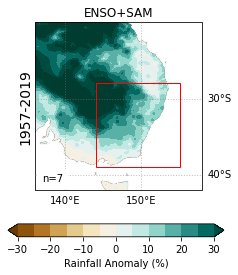

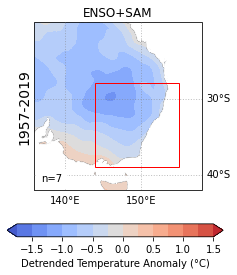

In [14]:
%run helpers/impactPlots.ipynb
for iFire in ['neg']:
    print('Fire:'+iFire)
    for iSeason in ['summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            ['enso+sam'], #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+SAM')
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), 
            ['enso+sam'],
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+SAM')

        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()

# And comparison between the enso indices

In [15]:
ensoIodEventsXr=allCompounds.sel(compound=['enso+iod','enso+sam','all3'], drop=True).any('compound')

In [16]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [17]:
ensoIodEventsLs

['nino4DmiSamsummer',
 'nino4DmiSamwinter',
 'nino4EastioSamsummer',
 'nino4EastioSamwinter',
 'nino3DmiSamsummer',
 'nino3DmiSamwinter',
 'nino3EastioSamsummer',
 'nino3EastioSamwinter',
 'ecCombinedDmiSamsummer',
 'ecCombinedDmiSamwinter',
 'ecCombinedEastioSamsummer',
 'ecCombinedEastioSamwinter',
 'nino34DmiSamsummer',
 'nino34DmiSamwinter',
 'nino34EastioSamsummer',
 'nino34EastioSamwinter',
 'cIndexDmiSamsummer',
 'cIndexDmiSamwinter',
 'cIndexEastioSamsummer',
 'cIndexEastioSamwinter',
 'eIndexDmiSamsummer',
 'eIndexDmiSamwinter',
 'eIndexEastioSamsummer',
 'eIndexEastioSamwinter']

In [18]:
ensoIodEventLs=[
    #'ecCombinedDmiSam',
    'eIndexDmiSam','cIndexDmiSam',
    #'nino34DmiSam'
]


pos
winter


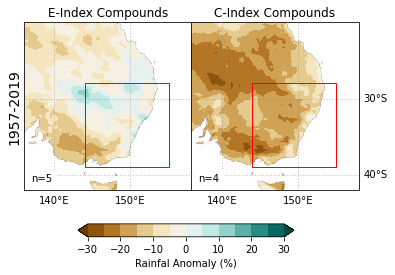

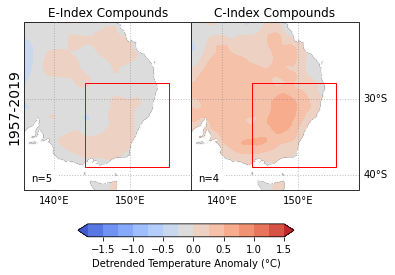

summer


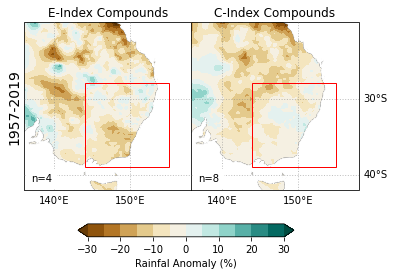

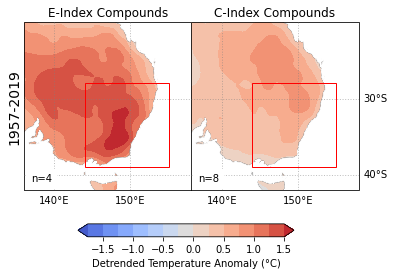

neg
winter


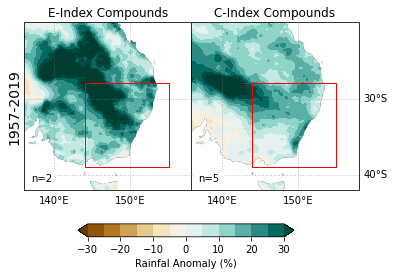

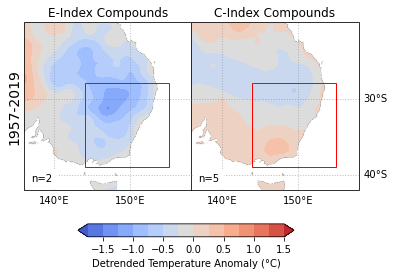

summer


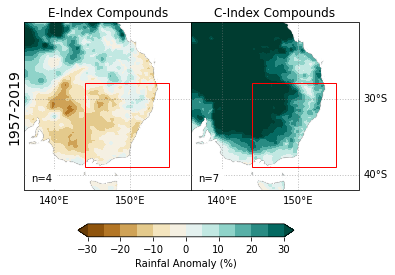

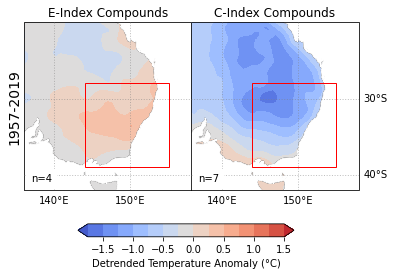

In [19]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'],
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs], 
            stipling=False, 
            showOcean=False,
            cbarLabel='Rainfal Anomaly (%)'
        )
        axs[0].set_title('E-Index Compounds')
        axs[1].set_title('C-Index Compounds')
        axs[0].text(-0.1, 0.5,  #xy relative to bottom left of axis
                        '1957-2019', #yearRange
                        rotation='vertical', transform=axs[0].transAxes, 
                        verticalalignment='center',fontsize=14)

        plt.savefig('figures/ECImpacts/'+iFire+iSeason.capitalize()+'Rain.pdf')
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize() + ' Temp'], 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs], 
            stipling=False, 
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        
        axs[0].set_title('E-Index Compounds')
        axs[1].set_title('C-Index Compounds')
        axs[0].text(-0.1, 0.5,  #xy relative to bottom left of axis
                        '1957-2019', #yearRange
                        rotation='vertical', transform=axs[0].transAxes, 
                        verticalalignment='center',fontsize=14)

        plt.savefig('figures/ECImpacts/'+iFire+iSeason.capitalize()+'Temp.pdf')
        plt.show()